In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"theraghavjuneja","key":"d24836b84ec39cad87a34aef68ea0283"}'}

In [2]:
import os
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)


!mv kaggle.json /root/.kaggle/


!chmod 600 /root/.kaggle/kaggle.json


In [3]:
!kaggle datasets download andrewmvd/medical-mnist

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/medical-mnist
License(s): other


In [4]:
with zipfile.ZipFile("/content/medical-mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("medicalMnist")


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import cv2


import warnings
warnings.filterwarnings("ignore")


tf.random.set_seed(42)
np.random.seed(42)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,        # Increa
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,           # Added zoom fo
    shear_range=0.1,          # Added shear fo
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Only rescaling for validation/test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


data_dir = '/content/medicalMnist'


class_names = os.listdir(data_dir)
print("Available classes:", class_names)
print("Number of classes:", len(class_names))

Available classes: ['HeadCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'AbdomenCT']
Number of classes: 6


In [6]:
all_images = []
all_labels = []


for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_dir, img_file)
            all_images.append(img_path)
            all_labels.append(class_idx)


train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Testing samples: {len(test_paths)}")


train_df = pd.DataFrame({
    'filename': train_paths,
    'class': [class_names[i] for i in train_labels]
})

test_df = pd.DataFrame({
    'filename': test_paths,
    'class': [class_names[i] for i in test_labels]
})

Training samples: 47163
Testing samples: 11791


In [7]:
BATCH_SIZE = 32
IMG_SIZE = 224


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        # Denormalize the image
        img = image_batch[i]
        img = img * 0.5 + 0.5  # Reverse the MobileNet preprocessing
        plt.imshow(img)
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis('off')
    plt.show()


Found 47163 validated image filenames belonging to 6 classes.
Found 11791 validated image filenames belonging to 6 classes.


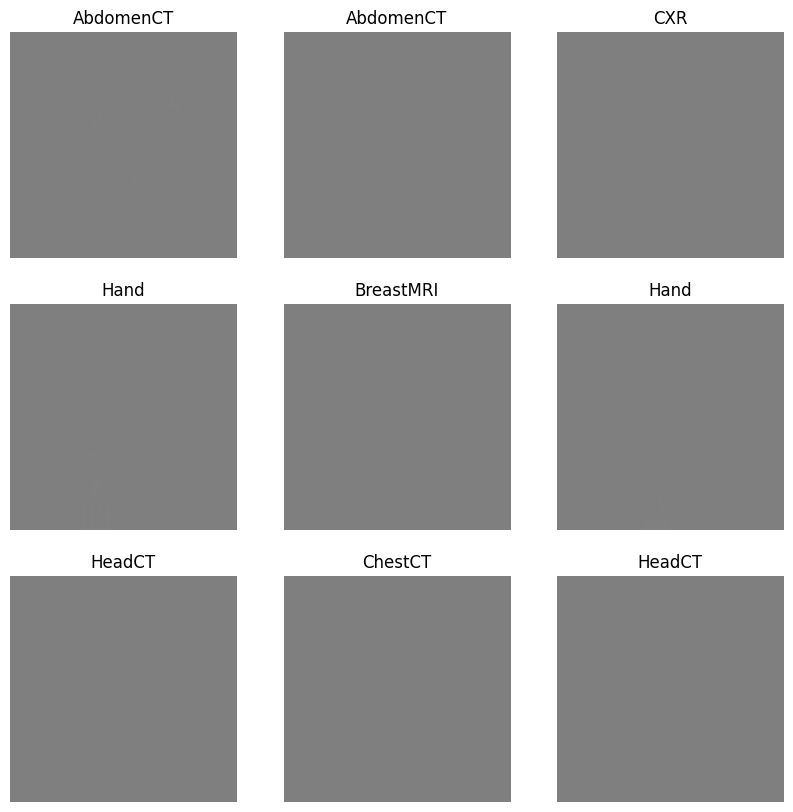

In [8]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)


In [9]:
sample_img = cv2.imread(all_images[0])
print(f"Original image shape: {sample_img.shape}")

Original image shape: (64, 64, 3)


In [10]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(class_names)):
    # Use MobileNetV2 as base model with transfer learning
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )


    base_model.trainable = False


    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),  # Add dropout for regularization
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])


    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = create_cnn_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,110 (9.27 MB)

 Trainable params: 172,870 (675.27 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [11]:
def create_custom_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(class_names)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
model = create_custom_cnn_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,012,966 (99.23 MB)

 Trainable params: 26,012,006 (99.23 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Training
EPOCHS = 15

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

print(f'\nTraining duration: {time.time() - start_time:.0f} seconds')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1/15
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 672s 440ms/step - accuracy: 0.9328 - loss: 0.2095 - val_accuracy: 0.9974 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 2/15
 119/1474 ━━━━━━━━━━━━━━━━━━━━ 8:58 397ms/step - accuracy: 0.9893 - loss: 0.0352

In [ ]:
test_generator.reset()
y_true = test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [ ]:
model.save('/content/medical_mnist_model.h5')
print("Model saved to /content/medical_mnist_model.h5")

In [ ]:
from google.colab import files

# Save the model
model.save('/content/medical_mnist_model.h5')
print("Model saved to /content/medical_mnist_model.h5")

# Automatically download the file
files.download('/content/medical_mnist_model.h5')


In [ ]:
model2 = create_cnn_model()
model.summary() # this is based on mobile net (so we can train this too but since we have enough images, i think our own model is good for this)